# Automated Trading Using Futu (Moo Moo)

### This project seeks to take alerts from analyst in discord channels execute trades via the Moo Moo brokerage platform. The following steps are taken
1. Open discord
2. Toggle to the Analyst's channel
3. Take screenshots of the discord channel
4. Parse the alerts
5. Execute trades
6. Repeat steps 3 to 5

In [2]:
from PIL import ImageGrab
import pytesseract
import numpy as np
import pandas as pd
from futu import *
from datetime import datetime, timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR
import re

# Check Accounts For Trading

In [ ]:
# Open Connection to Futu
trd_ctx = OpenSecTradeContext(filter_trdmarket=TrdMarket.US, host='127.0.0.1', port=11111, security_firm=SecurityFirm.FUTUSG)

# Retrieve list of accounts
ret, data = trd_ctx.get_acc_list()
if ret == RET_OK:
    print(data)

# Check for Any Open Orders

In [ ]:
# Define the environment and accountid
env = TrdEnv.SIMULATE
ID = 448100

# Open Connection to Futu
trd_ctx = OpenSecTradeContext(filter_trdmarket=TrdMarket.US, host='127.0.0.1', port=11111, security_firm=SecurityFirm.FUTUSG)

# Retrieve order list
ret, orders = trd_ctx.order_list_query(trd_env=env, acc_id = ID)
if ret == RET_OK:
    print(orders)

# Trading Functions

### Creating The Option From Alerts

#### Moo Moo option IDs are in the form of US.[ticker][yymmdd][direction][strike0] eg. US.SPY220526P395000
#### SAMPLE ALERT ['BTO QQQ 428P 2/6 @1.0 avg']

![Sample Alert.png](Personal-Projects/Moo Moo Automated Trade Execution/Sample Alert.png>)
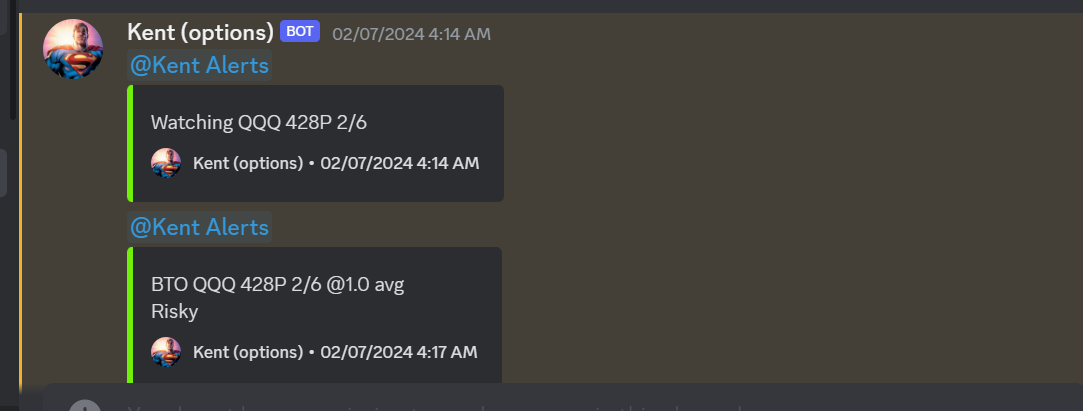

In [ ]:
def create_option():
    # Screenshot window
    snapshot = ImageGrab.grab()
    (left, upper, right, lower) = (450, 500, 1650, 950)

    # Crop Image
    im_crop = snapshot.crop((left, upper, right, lower))

    # Pytesseract for OCR
    pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\Edmund\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'
    img1 = np.array(im_crop)
    text = pytesseract.image_to_string(img1)
    text.splitlines()

    # Create alert and option
    action = ['BTO', 'STC']

    # Filter for string that contains BTO / STC
    alert = [s for s in text.splitlines() if any(xs in s for xs in action)]

    no_alert = 0

    if not alert == []:

        # Takes the last alert
        alert = alert[-1].split()

        ticker = alert[1].replace('$','')
        
        if ticker == 'SPX': # No trading SPX if its the alert
            return no_alert, no_alert, no_alert
        else:           
        
            # Processing strike
            strike = alert[2][:-1]
            if strike.find('.5') != -1:
                strike = strike.replace(".5","50") # If there is 50 cents change .5 to 50
            else:
                strike = strike +'00'

            # Processing direction (Call / Put)
            direction = alert[2][-1].upper() # last letter

            # Processing expiration
            expiration = alert[3].split('/')

            month = int(expiration[0])

            if month < 10: # if expiration month < 10 pad a 0
                month = '0'+str(month)

            day = int(expiration [1]) 
            if day < 10: # if expiration day < 10 pad a 0
                day = '0' + str(day)

            year = 24

            expiration = str(year) + str(month) + str(day)

            # Processing entry price
            price = alert[4].replace('@','')
            price = price.replace(',','')
            price = float(price)

            # Final option ID
            final = ticker+expiration+direction+strike
            final = 'US.'+final+'0'
            
            # Getting the signal (Buy / Sell)
            for i in action:
                if i in alert:
                    order = i
            
            return final, order, price
    else:
        return no_alert, no_alert, no_alert


### Checking Buying Power

In [ ]:
def check_bp(code, buy_price, env, ID):
    ret, bp = trd_ctx.acctradinginfo_query(order_type = OrderType.NORMAL, 
                                           code = code, 
                                           price = buy_price+0.06, 
                                           trd_env = env, 
                                           acc_id = ID)
    if ret == RET_OK:
        if bp['max_cash_buy'][0] >= 1:
            return True
        else:
            return False
    else:
        print('acctradinginfo_query error: ', bp)
        return False

### Checking Current Orders

##### Before submitting new/repeated orders, we need to check if there are existing unfilled order

In [ ]:
def check_order(code, which, env, ID):

    # Status to look for
    Status = ['SUBMITTING', 'SUBMITTED']

    # Get orders
    ret, orders = trd_ctx.order_list_query(trd_env = env, acc_id = ID)

    if ret == RET_OK:
        if orders.empty: # No current orders, proceed
            return True
        
        elif orders[(orders['code'] == code)]['code'].any(): # If there are orders for the same option ID, check their status
            if orders[(orders['code'] == code) & (orders['trd_side'] == which)]['order_status'].iloc[-1] in Status: # Current order being submitted, return false
                return False # Do not submit new order
            else:
                return True # Cases where order is cancelled, we can still submit a new order
        else:
            return True # No orders with the option ID, proceed
    else:
        print('order_list_query error: ', orders)
        return False

### Checking Positions

##### Before submitting orders, we need to check if we have an existing position

In [ ]:
def check_long_position(code, env, ID):
    ret, position = trd_ctx.position_list_query(trd_env = env, acc_id = ID)

    if ret == RET_OK:
        if position[position['code'] == code].empty: 
            return True # We do not have a position
        
        elif position[position['code'] == code]['can_sell_qty'][0] == 0: # If we had the same position before but already sold, can_sell_qty will be 0
            return True # No position
    else:
        print('position_list_query error: ', position)
        return False
            
def check_sell_position(code, env, ID):
    ret, position = trd_ctx.position_list_query(trd_env = env, acc_id = ID)

    if ret == RET_OK:
        if position[position['code'] == code].empty == False and position[position['code'] == code]['can_sell_qty'][0] >= 1: # We have an open position to sell
                return True
    else:
        print('position_list_query error: ', position)
        return False   

### Buy / Sell Execution

In [4]:
def buy(password, code, buy_price, env, ID):
    ret, unlock = trd_ctx.unlock_trade(password)  # Unlock trade first

    if ret == RET_OK:
        ret, data = trd_ctx.place_order(price = buy_price, 
                                        qty = 1, 
                                        code = code, 
                                        trd_side = TrdSide.BUY,
                                        trd_env = env, 
                                        acc_id = ID, 
                                        order_type = OrderType.NORMAL)
        if ret == RET_OK:
            print('submitted buy', code, buy_price)
        else:
            print('place_order error: ', data)
    
    else:
        print('unlock_trade failed: ', unlock)

def sell(password, code, sell_price, env, ID):
    ret, unlock = trd_ctx.unlock_trade(password)  # Unlock trade first

    if ret == RET_OK:
        ret, data = trd_ctx.place_order(price = sell_price, 
                                        qty = 1, 
                                        code = code, 
                                        trd_side = TrdSide.SELL, 
                                        trd_env = env, 
                                        acc_id = ID, 
                                        order_type = OrderType.NORMAL)
        if ret == RET_OK:
            print('submitted buy', code, sell_price)
        else:
            print('place_order error: ', data)
    
    else:
        print('unlock_trade failed: ', unlock)

### Cancelling Unfulfilled Orders

##### If orders have been submitted but not filled over a period of time, cancel it

In [ ]:
def check_unfullfilled(password, env, ID):
    Status = ['SUBMITTING', 'SUBMITTED']

    trd_ctx = OpenSecTradeContext(filter_trdmarket = TrdMarket.US, host = '127.0.0.1', port = 11111, security_firm = SecurityFirm.FUTUSG)  
    ret, uforders = trd_ctx.order_list_query(trd_env = env, acc_id = ID)

    if ret == RET_OK:
        if not uforders.empty:
            uforders['create_time'] = pd.to_datetime(uforders['create_time'])
            uforders = uforders[uforders['order_status'].isin(Status)] # Filter for submitted or submitting orders

            if not uforders.empty:
                uforders = uforders[(uforders['create_time'] + timedelta(seconds = 20)) < datetime.now() - timedelta(hours = 6)] # Check if orders have been unfilled for > 20s
                
                if not uforders.empty:
                    ret, unlock = trd_ctx.unlock_trade(password)  # Unlock trade first
                    
                    if ret == RET_OK:
                        ret, data = trd_ctx.cancel_all_order(trd_env = TrdEnv.REAL, acc_id = ID) # Cancel all open orders

    trd_ctx.close()                        

# Execution

### Here, the code will loop indefinitely until cancelled, executing trades whenever there is a new alert

In [ ]:
environment = TrdEnv.SIMULATE
accID = 448100 # 283726785215800433 real, 43368 sim cash, 448100 sim option
prev, prev_action, prev_price = create_option() # output 0, 0, 0 as a start
pwd_unlock = '---'
commands = []

while True:
    
    current, current_action, current_price = create_option()

    if current != 0 and (current != prev or current_action != prev_action or current_price != prev_price):
        combine = current_action + ' ' + current
        commands.append(combine)    

        if current_action == 'BTO':
            print('buy', current, current_price)
            
            trd_ctx = OpenSecTradeContext(filter_trdmarket = TrdMarket.US, host = '127.0.0.1', port = 11111, security_firm = SecurityFirm.FUTUSG)

            print('checking pos')
            if check_long_position(current, environment, accID):
                
                print('checking orders')
                if check_order(current, 'BUY', environment, accID):
                    
                    print('checking bp')
                    if check_bp(current, current_price, environment, accID):
                        
                        print('buying')
                        buy(pwd_unlock, current, current_price, environment, accID)

            trd_ctx.close()
            prev, prev_action, prev_price = current, current_action, current_price

        elif current_action == 'STC':
            print('sell', current, current_price)

            trd_ctx = OpenSecTradeContext(filter_trdmarket=TrdMarket.US, host='127.0.0.1', port=11111, security_firm=SecurityFirm.FUTUSG)

            print('checking pos')
            if check_sell_position(current, environment, accID):
                
                print('checking orders')
                if check_order(current, 'SELL', environment, accID):
                                            
                    print('selling')
                    sell(pwd_unlock, current, current_price, environment, accID)

            trd_ctx.close()
            prev, prev_action, prev_price = current, current_action, current_price
    
          
    check_unfullfilled(pwd_unlock, environment, accID)

    df = pd.DataFrame(commands)
    print(df)
    